In [1]:
import os, datetime
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import torch
import scipy
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
import scikit_posthocs as sp
import torchmetrics
#import pytorch_lightning as L
#from LN_malignancy_GNN.pytorch.run_model_torch import RunMalignancyModel
#from MLstatkit.stats import Delong_test

In [59]:
#top
gnn_cnn_noedge = './logs/training_chosen_split_undirected_graph_lncnn_noedgedim_no_pretrain_nofreeze_copy_attempt_ch2_class2_dp2_weight1_10rot_balance_feat256_feat64_64_nested_clinical_v18'
#graph_log_dir = './logs/training_chosen_split_undirected_graph_lncnn_noedgedim_no_pretrain_nofreeze_copy_attempt_ch2_class2_dp2_weight1_10rot_balance_feat256_feat64_64_nested_clinical_v18'
#graph_log_dir = './logs/training_graph_gct_lncnn_edgedim_self_undirected_noclin_2ch_v45'
#graph_log_dir = './logs/training_graph_gcn_lncnn_edgedim_self_undirected_noclin_2ch_v51'
#graph_log_dir = './logs/training_graph_lncnn_edgedim_self_undirected_noclin_2ch_v54'
graph_log_dir = './logs/training_graph_lncnn_edgedim_self_undirected_noclin_2ch_dp0_v56'
#graph_log_dir = './logs/training_gcn_lncnn_noedgedim_self_undirected_primary_v33'
#graph_log_dir = './logs/training_gcn_lncnn_noedgedim_self_undirected_1ch_v34'
#graph_log_dir = './logs/training_gcn_lncnn_noedgedim_self_undirected_2ch_v35'
#graph_log_dir = './logs/training_gcn_lncnn_noedgedim_self_undirected_2ch_222_v36'
#graph_log_dir = './logs/training_chosen_split_undirected_graph_lncnn_3edgedim_no_pretrain_nofreeze_copy_attempt_ch2_class2_dp1_weight1_10rot_balance_feat256_feat2_2_clinical_v22'
#gnn_cnn_3edge = './logs/training_chosen_split_undirected_graph_lncnn_3edgedim_no_self_connections_v23'
#gnn_cnn_3edge = './logs/training_graph_gct_lncnn_edgedim_self_undirected_noclin_2ch_v45'
#gnn_cnn_3edge = './logs/training_graph_lncnn_edgedim_self_undirected_noclin_2ch_dp0_2batch_v60'
#gnn_cnn_3edge = './logs/training_graph_lncnn_edgedim_self_undirected_noclin_2ch_dp0_2batch_v68'
#gnn_cnn_3edge = './logs/training_graph_lncnn_edgedim_self_undirected_noclin_2ch_dp0_2batch_v67'
gnn_cnn_3edge = './logs/training_graph_lncnn_edgedim_4batch_v76'
#gnn_cnn_3edge = './logs/training_graph_lncnn_edgedim_self_undirected_noclin_2ch_dp0_v56'
#gnn_cnn_3edge = './logs/training_graph_gcn_lncnn_edgedim_self_undirected_noclin_2ch_v51'
#gnn_cnn_3edge = './logs/training_graph_lncnn_edgedim_self_undirected_noclin_2ch_v54'
#graph_log_dir = './logs/training_chosen_split_undirected_graph_lncnn_0edgedim_self_connections_v24'
#gnn_cnn_primary = './logs/training_chosen_split_undirected_graph_lncnn_3edgedim_self_connections_primary_fixed_v26'
gnn_cnn_primary = './logs/training_gcn_lncnn_3edgedim_self_primary_v30'
#graph_log_dir = './logs/training_chosen_split_undirected_graph_lncnn_3edgedim_self_connections_primary_no_self_v27'
#no_graph_log_dir = './logs/training_chosen_split_no_graph_lncnn_noedgedim_no_pretrain_nofreeze_copy_attempt_ch2_class2_dp2_weight1_10rot_balance_feat256_nested_clinical_v15'
#no_graph_log_dir = './logs/training_nograph_lncnn_edgedim_self_undirected_2ch_222_v37'
#no_graph_log_dir = './logs/training_no_graph_gcn_lncnn_edgedim_self_undirected_noclin_2ch_v46'
#no_graph_log_dir = './logs/training_no_graph_lncnn_edgedim_self_undirected_noclin_2ch_v52'
no_graph_log_dir = './logs/training_nograph_lncnn_edgedim_self_undirected_noclin_2ch_dp0_2batch_v61'
liyuan_svm = '../../data/ln_malignancy/liyuan_svm_predictions'
liyuan_cnn = '../../data/ln_malignancy/liyuan_cnn_predictions'

folds_dir = '../../data/ln_malignancy/liyuan_folds'
folds_path = Path(folds_dir)

test_pred_file = 'metric_dfs/test_predictions.pkl'
val_pred_file = 'metric_dfs/val_predictions.pkl'

In [60]:
node_dict = pd.read_pickle('../../data/ln_malignancy/node_index_no_large.pkl')

In [61]:
node_dict['fold_dict']['fold_1'].append(node_dict['fold_dict']['fold_2'][0])

In [62]:
node_dict['fold_dict']['fold_2'].pop(0)

'90755105_8'

In [63]:
old_fold_dict = {}
for idx in range(5):
    old_fold_dict[f'fold_{idx}'] = [f.name.split('.')[0] for f in sorted(Path('../../data/ln_malignancy/liyuan_folds').glob(f"F{idx+1}/label/*"), key=lambda x: (int(x.name.split('.')[0].split('_')[0]), int(x.name.split('.')[0].split('_')[1])))]

In [64]:
for idx in range(5):
    node_dict['fold_dict'][f'fold_{idx}'] = sorted(node_dict['fold_dict'][f'fold_{idx}'], key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1])))

In [65]:
for idx in range(5):
    node_dict['node_idx'][f'fold_{idx}'] = [old_fold_dict[f'fold_{idx}'].index(ln) for ln in node_dict['fold_dict'][f'fold_{idx}']]

In [66]:
len(node_dict['fold_dict']['fold_1'])

305

In [67]:
test_gnn_cnn_noedge_pred = pd.read_pickle(os.path.join(gnn_cnn_noedge, test_pred_file))
test_graph_pred = pd.read_pickle(os.path.join(gnn_cnn_3edge, test_pred_file))
test_gnn_cnn_3edge_pred = pd.read_pickle(os.path.join(gnn_cnn_3edge, test_pred_file))
test_gnn_cnn_primary_pred = pd.read_pickle(os.path.join(gnn_cnn_primary, test_pred_file))
test_no_graph_pred = pd.read_pickle(os.path.join(no_graph_log_dir, test_pred_file))


In [68]:
test_graph_pred_small = test_graph_pred.copy(deep=True)
for idx in range(5):
    print(idx)
    for col in test_graph_pred_small.columns:
        print(col)
        test_graph_pred_small.loc[idx, col] = test_graph_pred.loc[idx, col][node_dict['node_idx'][f'fold_{idx}']]

0
val_auc
val_loss
val_m
targets
1
val_auc
val_loss
val_m
targets
2
val_auc
val_loss
val_m
targets
3
val_auc
val_loss
val_m
targets
4
val_auc
val_loss
val_m
targets


In [69]:
test_no_graph_pred_small = test_no_graph_pred.copy(deep=True)
for idx in range(5):
    print(idx)
    for col in test_no_graph_pred_small.columns:
        print(col)
        test_no_graph_pred_small.loc[idx, col] = test_no_graph_pred.loc[idx, col][node_dict['node_idx'][f'fold_{idx}']]

0
val_auc
val_loss
val_m
targets
1
val_auc
val_loss
val_m
targets
2
val_auc
val_loss
val_m
targets
3
val_auc
val_loss
val_m
targets
4
val_auc
val_loss
val_m
targets


In [70]:
test_graph_pred_large = test_graph_pred.copy(deep=True)
for idx in range(5):
    print(idx)
    for col in test_graph_pred_large.columns:
        print(col)
        test_graph_pred_large.loc[idx, col] = [ln for jdx, ln in enumerate(test_graph_pred.loc[idx, col]) if jdx not in node_dict['node_idx'][f'fold_{idx}']]

0
val_auc
val_loss
val_m
targets
1
val_auc
val_loss
val_m
targets
2
val_auc
val_loss
val_m
targets
3
val_auc
val_loss
val_m
targets
4
val_auc
val_loss
val_m
targets


In [71]:
test_no_graph_pred_large = test_no_graph_pred.copy(deep=True)
for idx in range(5):
    print(idx)
    for col in test_no_graph_pred_large.columns:
        print(col)
        test_no_graph_pred_large.loc[idx, col] = [ln for jdx, ln in enumerate(test_no_graph_pred.loc[idx, col]) if jdx not in node_dict['node_idx'][f'fold_{idx}']]

0
val_auc
val_loss
val_m
targets
1
val_auc
val_loss
val_m
targets
2
val_auc
val_loss
val_m
targets
3
val_auc
val_loss
val_m
targets
4
val_auc
val_loss
val_m
targets


In [103]:
#test_gnn_cnn_noedge_avg = []
test_gnn_cnn_3edge_avg = []
test_gnn_cnn_3edge_auc_avg = []
test_gnn_cnn_3edge_m_avg = []
test_gnn_cnn_primary_avg = []
test_graph_avg = []
test_no_graph_avg = []
test_no_graph_auc_avg = []
test_no_graph_m_avg = []
targets = []
test_graph_small_avg = []
test_graph_small_auc_avg = []
test_graph_small_m_avg = []
test_no_graph_small_avg = []
test_no_graph_small_auc_avg = []
test_no_graph_small_m_avg = []
targets_small = []
test_graph_large_avg = []
test_graph_large_auc_avg = []
test_graph_large_m_avg = []
test_no_graph_large_avg = []
test_no_graph_large_auc_avg = []
test_no_graph_large_m_avg = []
targets_large = []
for idx in range(5):
    #test_gnn_cnn_noedge_avg.extend(list(test_gnn_cnn_noedge_pred['val_auc'][idx]))
    test_graph_avg.extend(list(test_gnn_cnn_noedge_pred['val_auc'][idx]))
    #test_gnn_cnn_3edge_avg.extend(list(test_gnn_cnn_3edge_pred['val_auc'][idx]))
    test_gnn_cnn_3edge_auc_avg.extend(list(test_gnn_cnn_3edge_pred['val_auc'][idx]))
    test_gnn_cnn_3edge_m_avg.extend(list(test_gnn_cnn_3edge_pred['val_m'][idx]))
    test_gnn_cnn_3edge_avg = np.average([
                                         test_gnn_cnn_3edge_auc_avg, 
                                         test_gnn_cnn_3edge_m_avg,
                                        ], axis=0)
    test_gnn_cnn_primary_avg.extend(list(test_gnn_cnn_primary_pred['val_auc'][idx]))
    
    #test_no_graph_avg.extend(list(test_no_graph_pred['val_m'][idx]))
    test_no_graph_auc_avg.extend(list(test_no_graph_pred['val_auc'][idx]))
    test_no_graph_m_avg.extend(list(test_no_graph_pred['val_m'][idx]))
    test_no_graph_avg = np.average([
                                         test_no_graph_auc_avg, 
                                         test_no_graph_m_avg,
                                        ], axis=0)
    targets.extend(list(test_no_graph_pred['targets'][idx]))

    #test_graph_small_avg.extend(list(test_graph_pred_small['val_auc'][idx]))
    test_graph_small_auc_avg.extend(list(test_graph_pred_small['val_auc'][idx]))
    test_graph_small_m_avg.extend(list(test_graph_pred_small['val_m'][idx]))
    test_graph_small_avg = np.average([
                                         test_graph_small_auc_avg, 
                                         test_graph_small_m_avg,
                                        ], axis=0)
    #test_no_graph_small_avg.extend(list(test_no_graph_pred_small['val_m'][idx]))
    test_no_graph_small_auc_avg.extend(list(test_no_graph_pred_small['val_auc'][idx]))
    test_no_graph_small_m_avg.extend(list(test_no_graph_pred_small['val_m'][idx]))
    test_no_graph_small_avg = np.average([
                                         test_no_graph_small_auc_avg, 
                                         test_no_graph_small_m_avg,
                                        ], axis=0)
    targets_small.extend(list(test_graph_pred_small['targets'][idx]))
    
    #test_graph_large_avg.extend(list(test_graph_pred_large['val_auc'][idx]))
    test_graph_large_auc_avg.extend(list(test_graph_pred_large['val_auc'][idx]))
    test_graph_large_m_avg.extend(list(test_graph_pred_large['val_m'][idx]))
    test_graph_large_avg = np.average([
                                         test_graph_large_auc_avg, 
                                         test_graph_large_m_avg,
                                        ], axis=0)
    #test_no_graph_large_avg.extend(list(test_no_graph_pred_large['val_m'][idx]))
    test_no_graph_large_auc_avg.extend(list(test_no_graph_pred_large['val_auc'][idx]))
    test_no_graph_large_m_avg.extend(list(test_no_graph_pred_large['val_m'][idx]))
    test_no_graph_large_avg = np.average([
                                         test_no_graph_large_auc_avg, 
                                         test_no_graph_large_m_avg,
                                        ], axis=0)
    targets_large.extend(list(test_graph_pred_large['targets'][idx]))
    
#test_gnn_cnn_noedge_avg = np.array(test_gnn_cnn_noedge_avg)
test_graph_avg = np.array(test_graph_avg)
test_gnn_cnn_3edge_avg = np.array(test_gnn_cnn_3edge_avg)
test_gnn_cnn_primary_avg = np.array(test_gnn_cnn_primary_avg)
test_no_graph_avg = np.array(test_no_graph_avg)
targets = np.array(targets)

test_graph_small_avg = np.array(test_graph_small_avg)
test_no_graph_small_avg = np.array(test_no_graph_small_avg)
targets_small = np.array(targets_small)

test_graph_large_avg = np.array(test_graph_large_avg)
test_no_graph_large_avg = np.array(test_no_graph_large_avg)
targets_large = np.array(targets_large)
#test_graph_avg = np.mean(test_graph_avg, axis=0)    
#test_no_graph_avg = np.mean(test_no_graph_avg, axis=0)    

In [104]:
pred_avg_dict = {
    #'gnn_cnn_noedge': test_gnn_cnn_noedge_avg,
    'gnn_cnn_3edge': test_gnn_cnn_3edge_avg,
    'gnn_cnn_primary': test_gnn_cnn_primary_avg,
    'no_graph': test_no_graph_avg,
    }
small_avg_dict = {
    'gnn_cnn_3edge': test_graph_small_avg,
    'no_graph': test_no_graph_small_avg
}
large_avg_dict = {
    'gnn_cnn_3edge': test_graph_large_avg,
    'no_graph': test_no_graph_large_avg,
}

In [ ]:
t, p = scipy.stats.ttest_ind(test_graph_small_avg, test_graph_avg)
#t, p = scipy.stats.ttest_rel(test_no_graph_small_avg, test_no_graph_avg)
print(p)

In [ ]:
delong_results = [[(model1, model2), Delong_test(targets.ravel(), np.array(pred_avg_dict[model1]).ravel(), np.array(pred_avg_dict[model2]).ravel())] 
                  for model1 in pred_avg_dict for model2 in pred_avg_dict]
for res in delong_results:
    print(res)
#Delong_test(targets.ravel(), np.array(test_no_graph_avg).ravel(), test_graph_avg.ravel())

In [ ]:
delong_results = [[(model1, model2), Delong_test(targets_small.ravel(), np.array(small_avg_dict[model1]).ravel(), np.array(small_avg_dict[model2]).ravel())] 
                  for model1 in small_avg_dict for model2 in small_avg_dict]
for res in delong_results:
    print(res)
#Delong_test(targets.ravel(), np.array(test_no_graph_avg).ravel(), test_graph_avg.ravel())

In [ ]:
for idx in range(5):
    t1, p1 = scipy.stats.ttest_rel(val_graph_pred['val_m'][idx], val_no_graph_pred['val_m'][idx])
    t2, p2 = scipy.stats.ttest_rel(test_graph_pred['val_m'][idx], test_no_graph_pred['val_m'][idx])
    print(p1, p2)

In [17]:
# all of the metrics used in the evaluation, can add or remove as desired
#L.seed_everything(42)
auc_fn = torchmetrics.classification.BinaryAUROC()
acc_fn = torchmetrics.classification.BinaryAccuracy()
ap_fn = torchmetrics.classification.BinaryAveragePrecision()
spe_fn = torchmetrics.classification.BinarySpecificity()
sen_fn = torchmetrics.classification.BinaryRecall()

roc_fn = torchmetrics.classification.BinaryROC()
pr_fn = torchmetrics.classification.BinaryPrecisionRecallCurve()

In [18]:
# resets metric functions, should be run for each successive evaluation of probabilities as values entered into functions are persistent until reset
auc_fn.reset()
acc_fn.reset()
ap_fn.reset()
spe_fn.reset()
sen_fn.reset()
roc_fn.reset()
pr_fn.reset()

In [ ]:
fusion_avg = np.average((pred_avg_dict['gnn_cnn_3edge'], pred_avg_dict['no_graph']), axis=0)

In [ ]:
auc_fn(torch.tensor(fusion_avg), torch.tensor(targets))

In [105]:
for model in pred_avg_dict:
    print(model)
    print('auc:', auc_fn(torch.tensor(pred_avg_dict[model]), torch.tensor(targets)))
    print('acc:', acc_fn(torch.tensor(pred_avg_dict[model]), torch.tensor(targets)))
    print('ap:', ap_fn(torch.tensor(pred_avg_dict[model]), torch.tensor(targets)))
    print('sen:', sen_fn(torch.tensor(pred_avg_dict[model]), torch.tensor(targets)))
    print('spe:', spe_fn(torch.tensor(pred_avg_dict[model]), torch.tensor(targets)))
    

gnn_cnn_3edge
auc: tensor(0.9650)
acc: tensor(0.9206)
ap: tensor(0.9638)
sen: tensor(0.9209)
spe: tensor(0.9202)
gnn_cnn_primary
auc: tensor(0.9351)
acc: tensor(0.8670)
ap: tensor(0.9232)
sen: tensor(0.8641)
spe: tensor(0.8699)
no_graph
auc: tensor(0.9544)
acc: tensor(0.8994)
ap: tensor(0.9488)
sen: tensor(0.8986)
spe: tensor(0.9001)


In [106]:
for model in small_avg_dict:
    print(model)
    print('auc:', auc_fn(torch.tensor(small_avg_dict[model]), torch.tensor(targets_small)))
    print('acc:', acc_fn(torch.tensor(small_avg_dict[model]), torch.tensor(targets_small)))
    print('ap:', ap_fn(torch.tensor(small_avg_dict[model]), torch.tensor(targets_small)))
    print('sen:', sen_fn(torch.tensor(small_avg_dict[model]), torch.tensor(targets_small)))
    print('spe:', spe_fn(torch.tensor(small_avg_dict[model]), torch.tensor(targets_small)))
    

gnn_cnn_3edge
auc: tensor(0.9640)
acc: tensor(0.9187)
ap: tensor(0.9627)
sen: tensor(0.9191)
spe: tensor(0.9183)
no_graph
auc: tensor(0.9524)
acc: tensor(0.8964)
ap: tensor(0.9466)
sen: tensor(0.8956)
spe: tensor(0.8971)


In [107]:
for model in large_avg_dict:
    print(model)
    print('auc:', auc_fn(torch.tensor(large_avg_dict[model]), torch.tensor(targets_large)))
    print('acc:', acc_fn(torch.tensor(large_avg_dict[model]), torch.tensor(targets_large)))
    print('ap:', ap_fn(torch.tensor(large_avg_dict[model]), torch.tensor(targets_large)))
    print('sen:', sen_fn(torch.tensor(large_avg_dict[model]), torch.tensor(targets_large)))
    print('spe:', spe_fn(torch.tensor(large_avg_dict[model]), torch.tensor(targets_large)))
    

gnn_cnn_3edge
auc: tensor(0.9849)
acc: tensor(0.9565)
ap: tensor(0.9850)
sen: tensor(0.9565)
spe: tensor(0.9565)
no_graph
auc: tensor(0.9901)
acc: tensor(0.9565)
ap: tensor(0.9905)
sen: tensor(0.9565)
spe: tensor(0.9565)


In [ ]:
len(targets_small)

In [ ]:
graph_auc = auc_fn(torch.tensor(test_graph_avg), torch.tensor(targets))
no_graph_auc = auc_fn(torch.tensor(test_no_graph_avg), torch.tensor(targets))
graph_ap = ap_fn(torch.tensor(test_graph_avg), torch.tensor(targets))
no_graph_ap = ap_fn(torch.tensor(test_no_graph_avg), torch.tensor(targets))
graph_sen = sen_fn(torch.tensor(test_graph_avg), torch.tensor(targets))
no_graph_sen = sen_fn(torch.tensor(test_no_graph_avg), torch.tensor(targets))
graph_spe = spe_fn(torch.tensor(test_graph_avg), torch.tensor(targets))
no_graph_spe = spe_fn(torch.tensor(test_no_graph_avg), torch.tensor(targets))
print('auc:', graph_auc, no_graph_auc)
print('ap:', graph_ap, no_graph_ap)
print('sen:', graph_sen, no_graph_sen)
print('spe:', graph_spe, no_graph_spe)

In [ ]:
graph_fold_aucs = []
no_graph_fold_aucs = []
for idx in range(5):
    graph_fold_aucs.append(auc_fn((test_graph_pred['val_auc'][idx]), test_graph_pred['targets'][idx]))
    no_graph_fold_aucs.append(auc_fn((test_no_graph_pred['val_auc'][idx]), test_no_graph_pred['targets'][idx]))

print((graph_fold_aucs))
print((no_graph_fold_aucs))

In [58]:
log_path = Path('./logs')
metric_dict = {}
for pred_file in sorted(log_path.rglob('metric_dfs/*predictions.pkl'), key=lambda x: x.as_posix().split('/')[1].split('_')[-1]):
    #print(pred_file)
    if 'test_predictions' not in pred_file.as_posix(): continue
    if 'test_k' in pred_file.as_posix(): continue
    model = pred_file.as_posix().split('/')[1]
    if int(model.split('_')[-1].split('v')[-1]) < 30: continue
    pred_avg = []
    targets = []
    model = pred_file.as_posix().split('/')[1]
    #print(model)
    predictions = pd.read_pickle(pred_file)
    for idx in range(5):
        pred_avg.extend(list(predictions['val_auc'][idx]))
        targets.extend(list(predictions['targets'][idx]))
    #pred_avg = np.average(pred_avg, axis=0)
    #print(len(pred_avg), len(targets))
    pred_avg = np.array(pred_avg)
    targets = np.array(targets)
    auc = auc_fn(torch.tensor(pred_avg), torch.tensor(targets))
    ap = ap_fn(torch.tensor(pred_avg), torch.tensor(targets).to(torch.long))
    sen = sen_fn(torch.tensor(pred_avg), torch.tensor(targets))
    spe = spe_fn(torch.tensor(pred_avg), torch.tensor(targets))
    metric_dict[model] = [float(auc), float(ap), float(sen), float(spe)]

metric_df = pd.DataFrame(metric_dict, columns=['AUC', 'AP', 'SEN', 'SPE'], index=metric_dict.keys())
for key in metric_dict.keys():
    metric_df.loc[key] = metric_dict[key]
metric_df

,AUC,AP,SEN,SPE
training_gcn_lncnn_3edgedim_self_primary_v30,0.935149,0.923239,0.864127,0.869878
training_gcn_lncnn_noedgedim_self_primary_v31,0.934846,0.931177,0.86844,0.870597
training_gcn_lncnn_noedgedim_self_undirected_primary_v33,0.879371,0.873445,0.819554,0.818835
training_gcn_lncnn_noedgedim_self_undirected_1ch_v34,0.922049,0.915314,0.851905,0.875629
training_gcn_lncnn_noedgedim_self_undirected_2ch_v35,0.922945,0.916453,0.859094,0.860532
training_gcn_lncnn_edgedim_self_undirected_2ch_222_v36,0.937647,0.933264,0.872034,0.867721
training_gcn_lncnn_noedgedim_self_undirected_2ch_222_v36,0.916514,0.913727,0.852624,0.846873
training_nograph_lncnn_edgedim_self_undirected_2ch_222_v37,0.932476,0.918161,0.870597,0.872753
training_graph_gcn_spottune_edgedim_self_undirected_2ch_222_v39,0.938462,0.929815,0.87491,0.875629
training_graph_gcn_spottune_primary_edgedim_self_undirected_2ch_64_v40,0.930944,0.925828,0.857656,0.866283


{}

In [108]:
metrics = [0.965, 0.5, 0.954] 
metrics_small = [0.965, 0.5, 0.964, 0.954, 0.952]

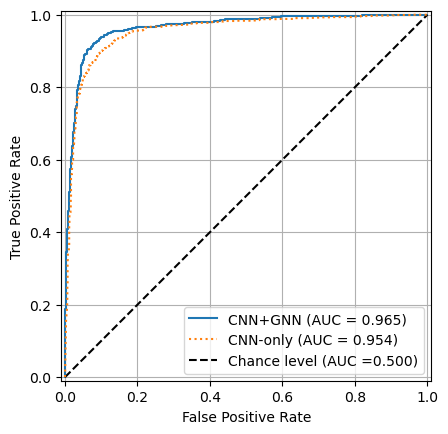

In [109]:
from sklearn.metrics import RocCurveDisplay
#figure = plt.figure()
#axes = figure.add_subplot(111)
display = RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['gnn_cnn_3edge'].ravel(), name='CNN+GNN', plot_chance_level=True)
#RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['gnn_cnn_primary'].ravel(), name='CNN+GNN+GTVp', plot_chance_level=False, ax=display.ax_)
RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['no_graph'].ravel(), name='CNN-only', plot_chance_level=False, ax=display.ax_)
plt.grid(visible=True, which='both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
handles, labels = plt.gca().get_legend_handles_labels()
line_styles = ['-', '--', ':', '-.']
for line, ls in zip(display.ax_.get_lines(), line_styles):
    line.set_linestyle(ls)
plt.legend([handles[idx] for idx in [0, 2, 1]], 
           [labels[idx].replace(''.join(labels[idx][-5:]), f'{metrics[idx]:.3f})')  for idx in [0, 2, 1]])
display.figure_.savefig(f"roc_curve_GNN_v7.png", dpi=600)
plt.show()

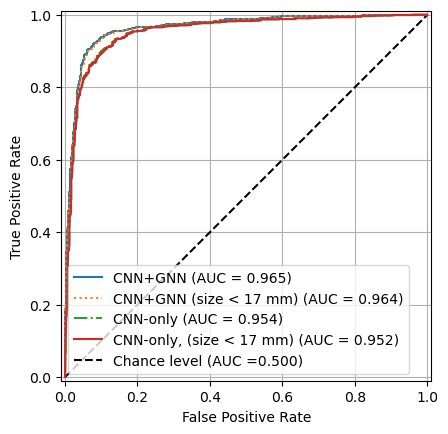

In [111]:
from sklearn.metrics import RocCurveDisplay
#figure = plt.figure()
#axes = figure.add_subplot(111)
display = RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['gnn_cnn_3edge'].ravel(), name='CNN+GNN', plot_chance_level=True)
RocCurveDisplay.from_predictions(targets_small.ravel(), small_avg_dict['gnn_cnn_3edge'].ravel(), name='CNN+GNN (size < 17 mm)', plot_chance_level=False, ax=display.ax_)
RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['no_graph'].ravel(), name='CNN-only', plot_chance_level=False, ax=display.ax_)
RocCurveDisplay.from_predictions(targets_small.ravel(), small_avg_dict['no_graph'].ravel(), name='CNN-only, (size < 17 mm)', plot_chance_level=False, ax=display.ax_)
plt.grid(visible=True, which='both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
handles, labels = plt.gca().get_legend_handles_labels()
line_styles = ['-', '--', ':', '-.']
for line, ls in zip(display.ax_.get_lines(), line_styles):
    line.set_linestyle(ls)
plt.legend([handles[idx] for idx in [0, 2, 3, 4, 1]], 
           [labels[idx].replace(''.join(labels[idx][-5:]), f'{metrics_small[idx]:.3f})') for idx in [0, 2, 3, 4, 1]])
display.figure_.savefig(f"roc_curve_GNN_small_v7.png", dpi=600)
plt.show()

In [ ]:
plt.ion()

In [ ]:
from sklearn.metrics import RocCurveDisplay
#figure = plt.figure()
#axes = figure.add_subplot(111)
display = RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['gnn_cnn_noedge'].ravel(), name='CNN+GNN', plot_chance_level=True)
RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['gnn_cnn_primary'].ravel(), name='CNN+GNN+GTVp', plot_chance_level=False, ax=display.ax_)
RocCurveDisplay.from_predictions(targets.ravel(), pred_avg_dict['no_graph'].ravel(), name='CNN-only', plot_chance_level=False, ax=display.ax_)
plt.grid(visible=True, which='both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
handles, labels = plt.gca().get_legend_handles_labels()
line_styles = ['-', '--', '-.', ':']
for line, ls in zip(display.ax_.get_lines(), line_styles):
    line.set_linestyle(ls)
plt.legend([handles[idx] for idx in [0, 2, 3, 1]], [labels[idx] for idx in [0, 2, 3, 1]])

display.figure_.savefig(f"roc_curve_GNN_zoom_v3.pdf", dpi=600)
plt.show()


In [ ]:
roc_fn = torchmetrics.classification.BinaryROC()
roc_fn.update(torch.tensor(test_graph_avg), torch.tensor(targets))
fig_, ax_ = roc_fn.plot(score=True)
roc_fn.reset()
roc_fn.update(torch.tensor(test_no_graph_avg), torch.tensor(targets))
roc_fn.plot(score=True, ax=ax_)
handles, labels = ax_.get_legend_handles_labels()
ax_.legend([f"CNN+GNN ({labels[0]})", f"CNN-only ({labels[1]})"]) 
fig_.savefig(f"roc_curve_top_comparison.pdf", dpi=600)

In [ ]:
display.figure_.savefig(f"roc_curve_GNN.png", dpi=600)

In [ ]:
len(test_graph_pred['targets'][4])

### Testing models

In [ ]:
graph_log_dir = './logs/training_chosen_split_undirected_graph_lncnn_noedgedim_no_pretrain_nofreeze_copy_attempt_ch2_class2_dp2_weight1_10rot_balance_feat256_feat64_64_nested_clinical_v18'
cnn_log_dir = './logs/training_chosen_split_no_graph_lncnn_noedgedim_no_pretrain_nofreeze_copy_attempt_ch2_class2_dp2_weight1_10rot_balance_feat256_nested_clinical_v15'
test_pred_file = 'metric_dfs/test_predictions.pkl'
gnn_config_file = os.path.join(graph_log_dir, 'csvlog_fold_0','lightning_logs','version_1','hparams.yaml')
cnn_config_file = os.path.join(no_graph_log_dir, 'csvlog_fold_0','lightning_logs','version_0','hparams.yaml')
graph_auc_models = [
    'model_epoch=93_val_loss=0.19_val_auc=0.98_val_m=0.91.ckpt',
    'model_epoch=42_val_loss=0.22_val_auc=0.97_val_m=0.91.ckpt',
    'model_epoch=89_val_loss=0.19_val_auc=0.98_val_m=0.88.ckpt',
    'model_epoch=73_val_loss=0.33_val_auc=0.94_val_m=0.88.ckpt',
    'model_epoch=58_val_loss=0.20_val_auc=0.98_val_m=0.90.ckpt',
]
graph_loss_models = [
    'model_loss_epoch=93_val_loss=0.19_val_auc=0.98_val_m=0.91.ckpt',
    'model_loss_epoch=52_val_loss=0.22_val_auc=0.97_val_m=0.91.ckpt',
    'model_loss_epoch=89_val_loss=0.19_val_auc=0.98_val_m=0.88.ckpt',
    'model_loss_epoch=73_val_loss=0.33_val_auc=0.94_val_m=0.88.ckpt',
    'model_loss_epoch=39_val_loss=0.20_val_auc=0.98_val_m=0.90.ckpt',
]
graph_m_models = [
    'model_m_epoch=92_val_loss=0.22_val_auc=0.97_val_m=0.92.ckpt',
    'model_m_epoch=57_val_loss=0.23_val_auc=0.97_val_m=0.91.ckpt',
    'model_m_epoch=26_val_loss=0.29_val_auc=0.95_val_m=0.90.ckpt',
    'model_m_epoch=65_val_loss=0.38_val_auc=0.93_val_m=0.92.ckpt',
    'model_m_epoch=43_val_loss=0.25_val_auc=0.97_val_m=0.92.ckpt',
]
cnn_auc_models = [
    'model_epoch=50_val_loss=0.84_val_auc=0.98_val_m=0.93.ckpt',
    'model_epoch=21_val_loss=0.76_val_auc=0.98_val_m=0.93.ckpt',
    'model_epoch=50_val_loss=0.56_val_auc=0.98_val_m=0.95.ckpt',
    'model_epoch=80_val_loss=0.91_val_auc=0.96_val_m=0.91.ckpt',
    'model_epoch=24_val_loss=0.77_val_auc=0.98_val_m=0.94.ckpt',
]
cnn_loss_models = [
    'model_loss_epoch=15_val_loss=0.43_val_auc=0.97_val_m=0.90.ckpt',
    'model_loss_epoch=00_val_loss=0.30_val_auc=0.95_val_m=0.87.ckpt',
    'model_loss_epoch=09_val_loss=0.39_val_auc=0.95_val_m=0.89.ckpt',
    'model_loss_epoch=00_val_loss=0.41_val_auc=0.90_val_m=0.85.ckpt',
    'model_loss_epoch=00_val_loss=0.38_val_auc=0.93_val_m=0.85.ckpt',
]
cnn_m_models = [
    'model_m_epoch=77_val_loss=1.05_val_auc=0.97_val_m=0.94.ckpt',
    'model_m_epoch=59_val_loss=1.00_val_auc=0.96_val_m=0.93.ckpt',
    'model_m_epoch=50_val_loss=0.56_val_auc=0.98_val_m=0.95.ckpt',
    'model_m_epoch=97_val_loss=1.14_val_auc=0.95_val_m=0.93.ckpt',
    'model_m_epoch=27_val_loss=0.52_val_auc=0.98_val_m=0.94.ckpt',
]

In [ ]:
gnn_config = yaml.safe_load(open(gnn_config_file, 'r'))
cnn_config = yaml.safe_load(open(cnn_config_file, 'r'))

In [ ]:
gnn_model = RunMalignancyModel(config=gnn_config['config'])
gnn_model.config['true_balance_classes'] = False
gnn_model.set_model()
gnn_model.set_data()
gnn_model.set_train_test_split()
gnn_model.set_data_module()
gnn_model.prepare_trainers()

for idx in [0,1,2,3,4]:
    gnn_model.trainers[idx].validate(gnn_model.model,
                           datamodule=gnn_model.data_module_cross_val[idx], 
                           ckpt_path=os.path.join(graph_log_dir, f"top_models_fold_{idx}", graph_auc_models[idx])
                          )
    gnn_model.trainers[idx].test(gnn_model.model,
                           datamodule=gnn_model.data_module_cross_val[idx], 
                           ckpt_path=os.path.join(graph_log_dir, f"top_models_fold_{idx}", graph_auc_models[idx])
                          )

In [ ]:
cnn_model = RunMalignancyModel(config=cnn_config['config'])
cnn_model.config['true_balance_classes'] = False
cnn_model.config['include_primary'] = False
cnn_model.set_model
cnn_model.set_data()
cnn_model.set_train_test_split()
cnn_model.set_data_module()
cnn_model.prepare_trainers()
for idx in [0,1,2,3,4]:

    cnn_model.set_model()
    cnn_model.set_callbacks(idx)
    cnn_model.trainers[idx] = L.Trainer(
                    max_epochs=cnn_model.config['n_epochs'],
                    accelerator="auto",
                    devices=cnn_model.config['gpu_device'] if torch.cuda.is_available() else None,
                    logger=[L.loggers.CSVLogger(save_dir=os.path.join(cnn_model.log_dir, f"csvlog_fold_{idx}")), L.loggers.TensorBoardLogger(save_dir=os.path.join(cnn_model.log_dir, f"tb_fold_{idx}"))],
                    callbacks=cnn_model.callbacks,
                    #check_val_every_n_epoch = 1,
                    #auto_lr_find=True
    )
    cnn_model.trainers[idx].validate(cnn_model.model,
                           datamodule=cnn_model.data_module_cross_val[idx], 
                           ckpt_path=os.path.join(cnn_log_dir, f"top_models_fold_{idx}", cnn_auc_models[idx])
                          )
    cnn_model.trainers[idx].test(cnn_model.model,
                           datamodule=cnn_model.data_module_cross_val[idx], 
                           ckpt_path=os.path.join(cnn_log_dir, f"top_models_fold_{idx}", cnn_auc_models[idx])
                          )
    

In [ ]:
for idx in [0,1,2,3,4]:
    gnn_model.best_checkpoints[f"fold_{idx}"] = {callback.monitor: callback.best_model_path for callback in gnn_model.trainers[idx].callbacks if 'ModelCheckpoint' in callback.__class__.__name__}
    gnn_model.best_checkpoints[f"fold_{idx}"]['val_auc'] = os.path.join(graph_log_dir, f"top_models_fold_{idx}", graph_auc_models[idx])
    gnn_model.best_checkpoints[f"fold_{idx}"]['val_loss'] = os.path.join(graph_log_dir, f"top_models_fold_{idx}", graph_loss_models[idx])
    gnn_model.best_checkpoints[f"fold_{idx}"]['val_m'] = os.path.join(graph_log_dir, f"top_models_fold_{idx}", graph_m_models[idx])
    
    cnn_model.best_checkpoints[f"fold_{idx}"] = {callback.monitor: callback.best_model_path for callback in cnn_model.trainers[idx].callbacks if 'ModelCheckpoint' in callback.__class__.__name__}
    cnn_model.best_checkpoints[f"fold_{idx}"]['val_auc'] = os.path.join(cnn_log_dir, f"top_models_fold_{idx}", cnn_auc_models[idx])
    cnn_model.best_checkpoints[f"fold_{idx}"]['val_loss'] = os.path.join(cnn_log_dir, f"top_models_fold_{idx}", cnn_loss_models[idx])
    cnn_model.best_checkpoints[f"fold_{idx}"]['val_m'] = os.path.join(cnn_log_dir, f"top_models_fold_{idx}", cnn_m_models[idx])

In [ ]:
#gnn_model.get_metrics_dataframe()
#gnn_model.get_predictions()
#cnn_model.get_metrics_dataframe()
cnn_model.get_predictions()

In [ ]:
liyuan_patient_order = []
for idx in range(5):
    tmp_fold_list = sorted(list(folds_path.glob(f"./F{idx+1}/label/*")))
    liyuan_patient_order.append([pat.as_posix().split('/')[-1].split('.')[0] for pat in tmp_fold_list])

In [ ]:
graph_patient_order = []
patients = pd.read_pickle('../../data/ln_malignancy/features_and_labels_110424.pkl')

In [ ]:
patients

In [ ]:
liyuan_cnn_preds = []
liyuan_svm_preds = []
liyuan_svm_targets = []
for idx in range(5):
    print(len(np.load(os.path.join(liyuan_cnn, f"F{idx+1}_pred.npy"))))
    liyuan_cnn_preds.extend(np.load(os.path.join(liyuan_cnn, f"F{idx+1}_pred.npy")))
    liyuan_svm_preds.extend(scipy.io.loadmat(os.path.join(liyuan_svm, f"F{idx+1}_ct_prediction.mat"))['test_pro'])
    liyuan_svm_targets.extend(scipy.io.loadmat(os.path.join(liyuan_svm, f"F{idx+1}_ct_prediction.mat"))['TestLabel'])
liyuan_svm_preds    

In [ ]:
os.execute('ls ../../data/ln_malignancy/liyuan_folds')

In [ ]:
for idx, (val1, val2) in enumerate(zip(test_graph_pred['targets'][0], liyuan_svm_targets[0])):
    print(idx, val1, val2)

In [ ]:
check_labels = []
for idx in range(len(targets_svm)):
    if targets_svm[idx][0] != svm_targets_remake[idx][0]:
        print(f"{idx+1} is problematic")
        check_labels.append((idx, targets_svm[idx], svm_targets_remake[idx]))
    print(idx+1, targets_svm[idx], svm_targets_remake[idx])

In [ ]:
cnn_auc = auc_fn(torch.tensor(np.array(liyuan_cnn_preds)), torch.tensor(targets))
svm_auc = auc_fn(torch.tensor(np.array(liyuan_svm_preds)[:,0]), torch.tensor(np.array(liyuan_svm_targets)))
cnn_ap = ap_fn(torch.tensor(liyuan_cnn_preds), torch.tensor(targets))
#svm_ap = ap_fn(torch.tensor(np.array(liyuan_svm_preds)[:,1]), torch.tensor(liyuan_svm_targets))
cnn_sen = sen_fn(torch.tensor(liyuan_cnn_preds), torch.tensor(targets))
#svm_sen = sen_fn(torch.tensor(np.array(liyuan_svm_preds)[:,1]), torch.tensor(liyuan_svm_targets))
cnn_spe = spe_fn(torch.tensor(liyuan_cnn_preds), torch.tensor(targets))
#svm_spe = spe_fn(torch.tensor(np.array(liyuan_svm_preds)[:,1]), torch.tensor(liyuan_svm_targets))
print('auc:', cnn_auc, svm_auc)
print('ap:', cnn_ap)
print('sen:', cnn_sen)
print('spe:', cnn_spe)

### R testing

In [27]:
from rpy2.robjects.packages import importr
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import numpy2ri, default_converter, pandas2ri, r

utils = importr('utils')
base = importr('base')

np_cv_rules = default_converter + numpy2ri.converter
numpy2ri.activate()
pandas2ri.activate()
utils.chooseCRANmirror(ind=1)

utils.install_packages('pROC')

proc = importr('pROC')

R[write to console]: Installing package into ‘/home/erichjs/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/pROC_1.18.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 696162 bytes (679 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to

g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/home/erichjs/R/x86_64-pc-linux-gnu-library/4.1/Rcpp/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppExports.cpp -o RcppExports.o
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/home/erichjs/R/x86_64-pc-linux-gnu-library/4.1/Rcpp/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c RcppVersion.cpp -o RcppVersion.o
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/home/erichjs/R/x86_64-pc-linux-gnu-library/4.1/Rcpp/include'    -fpic  -g -O2 -ffile-prefix-map=/build/r-base-4A2Reg/r-base-4.1.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c delong.cpp -o delong.o
g++ -std=gnu++14 -I"/usr/share/R/include" -DNDEBUG  -I'/

installing to /home/erichjs/R/x86_64-pc-linux-gnu-library/4.1/00LOCK-pROC/00new/pROC/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (pROC)
R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/RtmpoQ549C/downloaded_packages’
R[write to console]: 
R[write to console]: 



In [ ]:
'gnn_cnn_noedge': test_gnn_cnn_noedge_avg,
    'gnn_cnn_3edge': test_gnn_cnn_3edge_avg,
    'gnn_cnn_primary': test_gnn_cnn_primary_avg,
    'no_graph': test_no_graph_avg,

In [116]:
roc1 = proc.roc(targets,pred_avg_dict['gnn_cnn_3edge'])
roc2 = proc.roc(targets, pred_avg_dict['no_graph'])

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



In [118]:
roc1 = proc.roc(targets_small,small_avg_dict['gnn_cnn_3edge'])
roc2 = proc.roc(targets_small, small_avg_dict['no_graph'])

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



In [114]:
roc1 = proc.roc(targets_large,large_avg_dict['gnn_cnn_3edge'])
roc2 = proc.roc(targets_large, large_avg_dict['no_graph'])

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



In [113]:
print(proc.ci(roc1))
print(proc.ci(roc2))

[0.9572209  0.96398605 0.9707512 ]
[0.94424472 0.95243991 0.96063511]


In [119]:
proc.roc_test(roc1, roc2, method='delong', alternative='greater')

<rpy2.robjects.vectors.ListVector object at 0x7fb566b4eb40> [RTYPES.VECSXP]
R classes: ('htest',)
[StrSexpVe..., StrSexpVe..., FloatSexp..., FloatSexp..., ..., FloatSexp..., FloatSexp..., ListSexpV..., ListSexpV...]
  alternative: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7fb566b4e840> [RTYPES.STRSXP]
R classes: ('character',)
['greater']
  data.names: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7fb566adc240> [RTYPES.STRSXP]
R classes: ('character',)
['structur..., '1, 1, 1,..., '1, 1, 1,..., '1, 1, 1,..., ..., '    0L, ..., '    0L, ..., '    0L, ..., '    0L),...]
  estimate: <class 'numpy.ndarray'>
  array([0.96398605, 0.95243991])
  null.value: <class 'numpy.ndarray'>
  array([0.])
...
  method: <class 'numpy.ndarray'>
  array([0.00489698, 0.0181953 ])
  conf.int: <class 'numpy.ndarray'>
  array([0.00033272])
<rpy2.robjects.vectors.ListVector object at 0x7fb566b4eb40> [RTYPES.VECSXP]
R classes: ('htest',)
[StrSexpVe..., StrSexpVe..., FloatSexp..., FloatSexp..., ..., FloatSexp..., FloatSexp..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x7fb566b4eb40> [RTYPES.VECSXP]
R classes: ('htest',)
[StrSexpVe..., StrSexpVe..., FloatSexp..., FloatSexp..., ..., FloatSexp..., FloatSexp..., ListSexpV..., ListSexpV...]